In [92]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import glob
import os
import time
import xarray as xr

import dask.array as da
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

import seaborn as sns
sns.set_style('white')
sns.set_context("talk") #[poster, paper, talk, notebook]

In [93]:
which_year = 2018

#### Import compiled_SUPERsnow.nc

In [94]:
fname = '~/Documents/projects/thesis/results/output/compiled_SUPERsnow.nc'

#ds full
ds = xr.open_dataset(fname,  chunks={'time':1,'x':1000,'y':1000})
ds.close()

#~~~~~~~~~~~~~~ds small
dsmall = ds.sel(time='{}'.format(which_year))
dsmall.close()

ds = dsmall
ds.close()

#~~~~~~~~~~~ds peak
# dpeak = ds.isel(time=[0,7,18,30,42,49]) #0,7,22,28,41,49]
# dpeak.close()

# ds = dpeak
# ds.close()
# ds

#### Plotting features:

In [95]:
# legends/labels
d_str = pd.to_datetime(ds['time'].values).strftime("%m-%d-%Y")
print('number of legend labels:', len(d_str))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# fontsize, linewidth, etc.
fs_titles = 24
fs_labels = 24
fs_axes = 20
fs_text = 20
fs_legend = 20

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def color_palette(palette_type, show_pal=False):
               
    if palette_type is 'q' : #'qualitative' or 'q':  
    # qualitative:
        c_pal = sns.color_palette("Dark2", ds.time.size)
        if show_pal==True:
            c_shw = sns.palplot(c_pal)
        
    
    elif palette_type is 's' : #'sequential' or 's':
    # sequential:
        c_pal = sns.color_palette(sns.cubehelix_palette(ds.time.size, start=.7, rot=-.75,dark=.25, light=.75)) # create color palette (plt.plot(c=c_pal[i]))
        if show_pal==True:
            c_shw = sns.palplot(sns.cubehelix_palette(ds.time.size, start=.7, rot=-.75,dark=.25, light=.75)) # show colors
        
    
    elif palette_type is 'd' : #'diverge' or 'd':
    # diverging: 
        c_pal = sns.color_palette("RdBu_r", ds.time.size)
        if show_pal==True:
            c_shw = sns.palplot(c_pal)
        
    return c_pal 

# c_pal = color_palette('s', show_pal=True)




number of legend labels: 2


#### FUNCTIONS

In [96]:
# # FUNCTION - standardize lidar by mean
# def standard(x):
#     a = np.where(x>0) #, x, np.nan)
#     return x/np.nanmean(a)

# s = xr.apply_ufunc(standard, ds.snow, dask='parallelized', output_dtypes=[np.float32])

In [97]:
# for i in range(s.time.size):
   
#     plt.imshow(s[i])
#     plt.colorbar()
#     plt.show()

In [98]:
# # FUNCTION - subtracts mean
# def minus_mean(x):
#     a = np.where(x>0) #, x, np.nan)
#     return x - np.nanmean(a)


In [99]:
# FUNCTION - histogram
def histogram(x):
    '''makes histogram for all values >0 in lidar images'''
    h, bx = np.histogram(x[x !=0], bins=binx)
    return h, bx[:-1]

In [100]:
# FUNCTION - plot histogram
def step_hist_plt(hist, bin_x, date_iter, axis, line_color, alpha=0.4, lw=2, shaded=True):
    
    
    if shaded is True:
        a.step(bx,h, lw=lw, c=line_color[i], label = d_str[i])
        a.fill_between(bx,h, step="pre", alpha=alpha)
        
    if shaded is False:
        a.step(bx,h, lw=lw, c=line_color[i], label = d_str[i])

#### call functions and plot (color options above by font sizes)

[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.5s


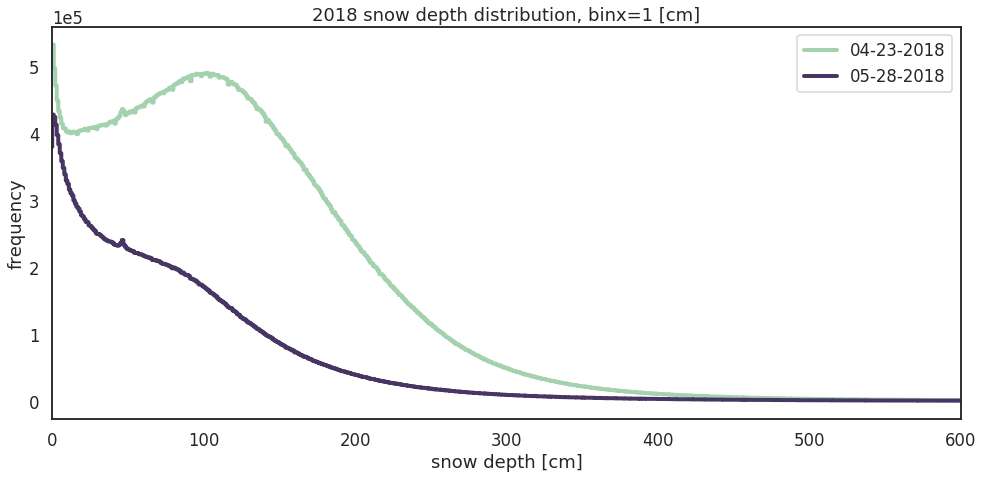

In [101]:
binx = np.arange(0,2500,1) #(start, stop, step by [cm])
# binx = np.arange(0,250,0.01)

f=plt.figure(num=0, figsize=(14,7))
a=plt.gca()


# with ProgressBar(): #ATTEMPTING TO RESCALE
#     for i in range(ds.time.size):
#         s = xr.apply_ufunc(standard, ds.snow, dask='parallelized', output_dtypes=[np.float32])
# #         mm_s = xr.apply_ufunc(minus_mean, ds.snow, dask='parallelized', output_dtypes=[np.float32])
#         h, bx = xr.apply_ufunc(histogram, s[i].values/10, dask='parallelized', output_dtypes=[np.float32])
#         step_hist_plt(h, bx, i, a, alpha=0.2, lw=1)

with ProgressBar(): #SAVED FIGS FROM HERE
    for i in range(ds.time.size):
        h, bx = xr.apply_ufunc(histogram, ds.snow[i].values/10, dask='parallelized', output_dtypes=[np.float32])
        c_pal = color_palette('s')
        step_hist_plt(h, bx, i, a, c_pal, alpha=0.2, lw=4, shaded=False)
    
#     a.set_title('Snow distribution nearest peak SWE flight date', fontsize=fs_titles)
#     a.set_title('{} snow depth distribution, binx=1 [cm]'.format(yr), fontsize=fs_titles)
    a.set_title('{} snow depth distribution, binx=1 [cm]'.format(which_year))#, fontsize=fs_titles)
#     a.set_xlim(0,500)
    a.set_xlim(0,600)
    a.set_xlabel('snow depth [cm]')#,fontsize=fs_axes)
    a.set_ylabel('frequency')#, fontsize=fs_axes)
    a.legend()#prop={'size': fs_legend})
    a.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    plt.tight_layout()
#     plt.savefig('/home/meganmason/Documents/projects/thesis/figures/working/early_fall/{}_dist_smaller'.format(which_year), dpi=300)
#     plt.show()